# IRRADIANCIA RESUELTA ESPECTRALMENTE

En este notebook se va a comparar los resultados de iluminación para un día concreto con dos métodos:
1. Irradiancia resuelta espectralmente y la curva fotópica
2. Aproximación con constante de 105 lm/W. 

## 1- IRRADIANCIA RESUELTA ESPECTRALMENTE Y CURVA FOTÓPICA

Librerías utilizadas

In [1]:
from pvlib import spectrum, solarposition, irradiance, atmosphere
import pandas as pd
import matplotlib.pyplot as plt
import module_AoiGrids as gr
import module_Cell as cell
from scipy.interpolate import InterpolatedUnivariateSpline as interp

Se definen las características del lugar y del módulo. 

In [2]:
caracteristics_place={
    'lat':40.544,
    'lon':-3.613,
    'tz':'Europe/Madrid',
    'date':'2021-06-21 8:00',
    'pressure':92350,
    'water_vapor_content':0.6,
    'tau500':0.1,
    'ozone':0.308,
    'albedo':0.2,
    }
caracteristics_module={    
    'tilt':30,
    'surface_azimuth':180,
    'radius':0.6,
    'area':179*10**-6
    }

Definición y obtención de datos de irradiancia y de características del emplazamiento para poder obtener la distribución espectral

In [3]:
times = pd.date_range(caracteristics_place['date'], freq='60min', periods=14,tz=caracteristics_place['tz'])
solpos = solarposition.get_solarposition(times, caracteristics_place['lat'], caracteristics_place['lon'])
aoi = irradiance.aoi(caracteristics_module['tilt'], caracteristics_module['surface_azimuth'], solpos.apparent_zenith, solpos.azimuth)
relative_airmass = atmosphere.get_relative_airmass(solpos.apparent_zenith,model='kasten1966')

In [4]:
spectra = spectrum.spectrl2(
    apparent_zenith=solpos.apparent_zenith,
    aoi=aoi,
    surface_tilt=caracteristics_module['tilt'],
    ground_albedo=caracteristics_place['albedo'],
    surface_pressure=caracteristics_place['pressure'],
    relative_airmass=relative_airmass,
    precipitable_water=caracteristics_place['water_vapor_content'],
    ozone=caracteristics_place['ozone'],
    aerosol_turbidity_500nm=caracteristics_place['tau500'],
)

Dibujo de la distribución espectral 

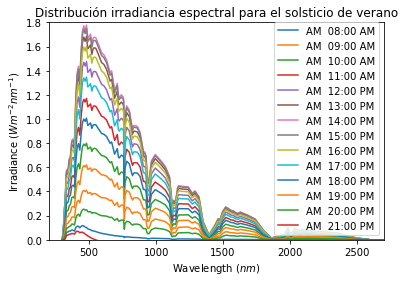

In [5]:
plt.figure()
plt.plot(spectra['wavelength'], spectra['poa_global'])
plt.xlim(200, 2700)
plt.ylim(0, 1.8)
plt.ylabel(r"Irradiance ($W m^{-2} nm^{-1}$)")
plt.xlabel(r"Wavelength ($nm$)")
plt.title("Distribución irradiancia espectral para el solsticio de verano")
time_labels = times.strftime("%H:%M %p")
labels = [
    "AM  {}".format(*vals)
    for vals in zip(time_labels)]
plt.legend(labels)
plt.show()

### CURVA FOTOPICA VALORES

Se extraen los valores normalizados de la curva fotópica en tanto por uno

In [6]:

effic=[0.000039,0.000120,0.000396,0.001210,0.004000,0.011600,0.023000,0.038000,0.060000,0.090980,0.139020,0.208020,0.32300,0.444310, 0.503000,0.710000,0.862000,0.954000,0.994950,1.000000,0.995000,0.952000,0.870000,0.757000,0.631000,0.503000,0.381000,0.265000,0.175000, 0.107000,0.061000,0.032000,0.017000,0.008210,0.004102,0.002091,0.001047,0.000520,0.000249,0.000120,0.000060,0.000030]
wave_len=[380,390,400,410,420,430,440,450,460,470,480,490,500,507,510, 520, 530, 540, 550,555,560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770]

effic_=pd.Series(effic)
effic_.index=wave_len


Dibujo de la curva fotópica

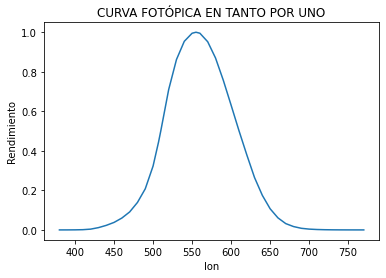

In [7]:
effic_.plot()
plt.xlabel('lon')
plt.ylabel('Rendimiento')
plt.title("CURVA FOTÓPICA EN TANTO POR UNO")
plt.show()

Se guarda la curva fotópica en forma de función. 

In [8]:
photopic_curve=interp(wave_len,effic,k=3)

### USO CURVA FOTOPICA CON LA IRRADIANCIA ESPECTRAL

Se aplica a la irradiancia espectral la curva fotópica y se dibuja el resultado real de de Lumenes por longitud de onda efectivamente utilizados para iluminar

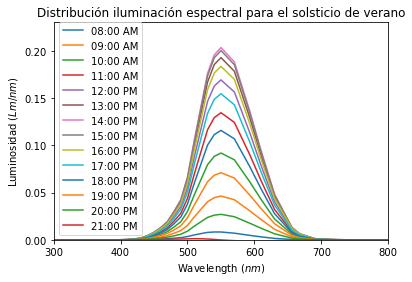

In [9]:
irrad_phot=[]
for i in range(len(spectra['poa_global'])):
    irrad_phot.append(spectra['poa_global'][i]*photopic_curve(spectra['wavelength'][i])*caracteristics_module['area']*683)

plt.figure()
plt.plot(spectra['wavelength'], irrad_phot)
plt.xlim(300, 800)
plt.ylim(0, 0.23)
plt.ylabel(r"Luminosidad ($Lm/nm$)")
plt.xlabel(r"Wavelength ($nm$)")
plt.title("Distribución iluminación espectral para el solsticio de verano")
time_labels = times.strftime("%H:%M %p")
labels = [
    "{}".format(*vals)
    for vals in zip(time_labels)
]
plt.legend(labels)
plt.show()

Esta distribución es un sistema aditivo. Se puede obtener el valor de la irradianciailuminación total a una hora concreta haciendo el sumatorio del producto de cada longitud de onda por el valor de irradiancia espectral. 

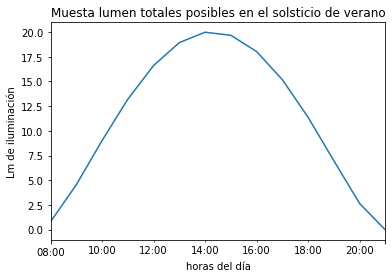

In [10]:
hour_irrad=[]
for i in range(len(irrad_phot[0])):
    a=0
    for j in range(len(irrad_phot)):
        if spectra['wavelength'][j]>=380 and spectra['wavelength'][j]<=770 :
                a=a+(float(spectra['wavelength'][j])-float(spectra['wavelength'][j-1]))*float(irrad_phot[j][i])
    hour_irrad.append(a)

hour_irrad=pd.Series(hour_irrad)
hour_irrad.index=times
hour_irrad.plot()
plt.xlabel('horas del día')
plt.ylabel('Lm de iluminación')
plt.title("Muesta lumen totales posibles en el solsticio de verano")
plt.show()


## 2- ILUMINACIÓN CON LA CONSTANTE CONSIDERADA

En el proyecto se propone y justifica con un esutdio el uso de la constante de 105 lm/W como una media para evitar hacer todo el estudio espectral para cada momento del año. Se compara el resultado anterior con la constante propuesta

In [11]:
data_location=gr.get_data_location(caracteristics_place,caracteristics_module,caracteristics_place['date']) 
lum_no_cell_=[]
for i in range(len(data_location['AOI'])):    
    lum_no_cell_.append(cell.from_rad_to_lum(data_location['POA_direct'][i],caracteristics_module['area']))
lum_no_cell=lum_no_cell_+cell.from_rad_to_lum(data_location['POA_diffuse'],caracteristics_module['area'])

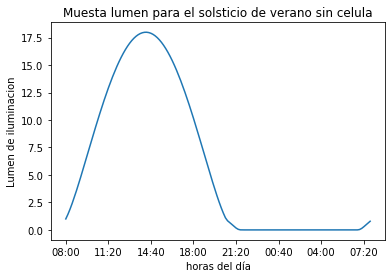

In [12]:
lum_no_cell.plot(label='iluminación modulo ')
plt.xlabel('horas del día')
plt.ylabel('Lumen de iluminacion')
plt.title("Muesta lumen para el solsticio de verano sin celula")
plt.show()

### CONCLUSIONES

Los lúmenes totales obtenidos con la irradiancia espectral son algo mayores en proporción con los obtenidos con la constante. La forma de la curva coincide completamente. Se asume esta diferencia a que la iluminación con la irradiancia resuelta espectralmente y la curva fotópica tienen en cuenta unas condiciones de cielo normalizadas, mientras que la constante tiene en cuenta unas condiciones medias del cielo, por lo tanto es normal que sea algo menor. Se concluye como ótpima la constante de 105 lm/W para el proyecto. 